In [1]:
import xarray as xr
import xcdat as xc
import numpy as np
import xskillscore as xs
import xesmf

Summary:
This notebook compares using cdat regridding method, and the methods supported by xcdat, for regridding a dataset without mask, precipitation (PRECT).
In the results shown in this case:
1. CDAT convervative and XCDAT conservative method shows a notable patten in their difference
2. The XCDAT results is validated with xesmf to make sure there isn't any issue in implementation.
3. After comparing with a third regridder: regrid2, it appears to be cdat-esmf method is an outliner. All input data with their bounds are exactly the same, there might be a problem with the cdat-esmf interface. 

Data for testing available from :https://web.lcrc.anl.gov/public/e3sm/zhang40/cdat-migration-fy24/test_data/


In [2]:
# Data can be found at https://web.lcrc.anl.gov/public/e3sm/zhang40/cdat-migration-fy24/test_data/
f_a = '/Users/zhang40/Downloads/xcdat/GPCP_v3.2-PRECT-ANN-global_test.nc' 
f_b = '/Users/zhang40/Downloads/xcdat/GPCP_v3.2-PRECT-ANN-global_ref.nc' 

In [3]:
# Regridding with cdat
import cdms2

var = 'PRECT'
var1 = cdms2.open(f_a)('PRECT',squeeze=1)
var2 = cdms2.open(f_b)(var,squeeze=1)

In [4]:
var2_conserv_cdat = var2.regrid(
            var1.getGrid(),
            regridTool='esmf',
            regridMethod='conservative',
        )
var2_bilinear_cdat = var2.regrid(
            var1.getGrid(),
            regridTool='esmf',
            regridMethod='bilinear',
        )

In [5]:
var2_regrid2_cdat = var2.regrid(
            var1.getGrid(),
            regridTool='regrid2',
        )

In [6]:
# Regridding with xcdat
tas_a = xr.open_dataset(f_a)
tas_b = xr.open_dataset(f_b)

In [7]:
tas_a = tas_a.bounds.add_missing_bounds()
tas_b = tas_b.bounds.add_missing_bounds()

In [8]:
print('Check if bounds of all input datasets are identical')
print(np.array_equal(var1.getGrid().getBounds()[0] , tas_a.lat_bnds))
print(np.array_equal(var1.getGrid().getBounds()[1] , tas_a.lon_bnds))

print(np.array_equal(var2.getGrid().getBounds()[0] , tas_b.lat_bnds))
print(np.array_equal(var2.getGrid().getBounds()[1] , tas_b.lon_bnds))

Check if bounds of all input datasets are identical
True
True
True
True


In [10]:
output_grid = tas_a.regridder.grid

tas_b_regrid_conservative_normed = tas_b.regridder.horizontal(
            var, output_grid, tool='xesmf', method='conservative_normed'
        )

tas_b_coarse_normed = tas_b_regrid_conservative_normed[var]

tas_b_regrid_bilinear = tas_b.regridder.horizontal(
            var, output_grid, tool='xesmf', method='bilinear'
        )

tas_b_coarse_bilinear = tas_b_regrid_bilinear[var]


In [11]:
# Convert cdat object to xarray
var2_conserv_cdat_xarray = tas_b_coarse_normed.copy()
var2_conserv_cdat_xarray.values = var2_conserv_cdat.data

var2_bilinear_cdat_xarray = tas_b_coarse_normed.copy()
var2_bilinear_cdat_xarray.values = var2_bilinear_cdat.data

var2_regrid2_cdat_xarray = tas_b_coarse_normed.copy()
var2_regrid2_cdat_xarray.values = var2_regrid2_cdat.data

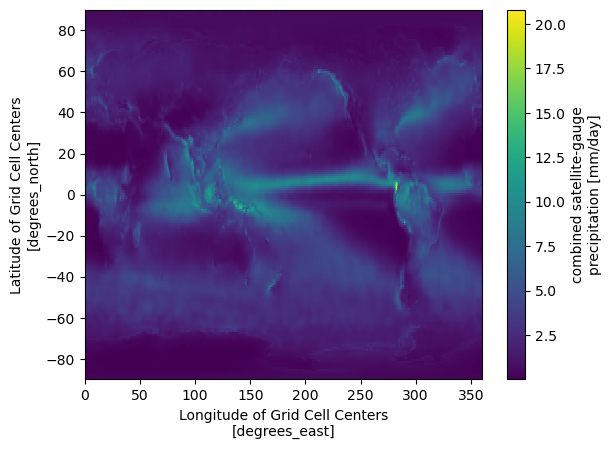

In [12]:
var2_conserv_cdat_xarray.plot()

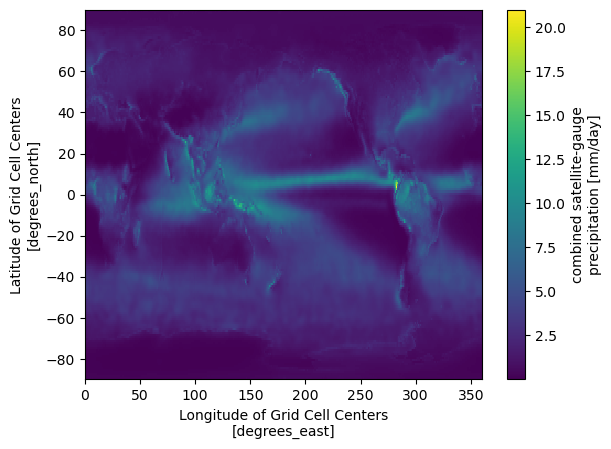

In [13]:
tas_b_coarse_normed.plot()

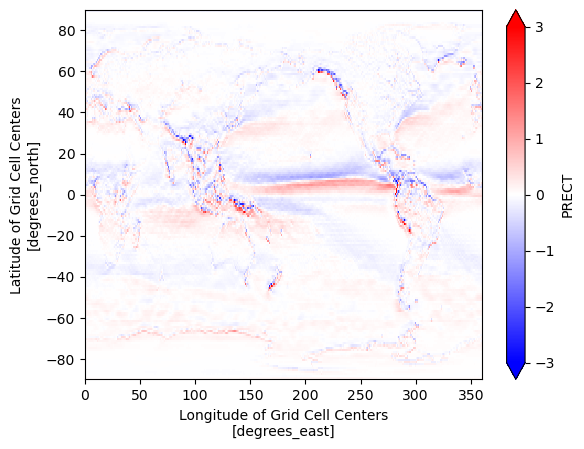

In [14]:
# Plot difference: CDAT conservative vs XCDAT conservative
(var2_conserv_cdat_xarray-tas_b_coarse_normed).plot(cmap = 'bwr', vmin = -3, vmax=3)

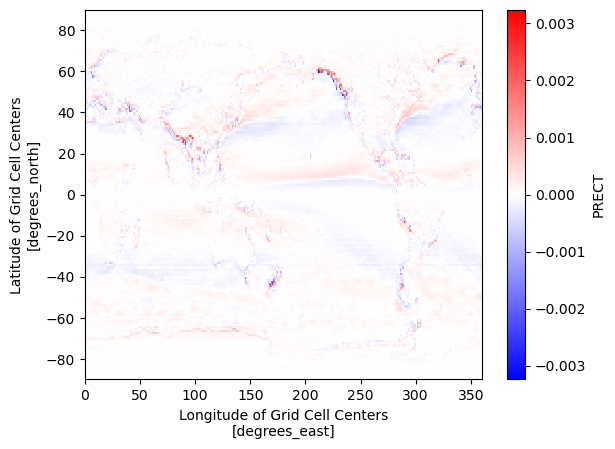

In [15]:
(var2_regrid2_cdat_xarray-tas_b_coarse_normed).plot(cmap = 'bwr')

In [16]:
def print_stats(arr0, arr1, arr2, arr3,label0="Original", label1="conserv_cdat", label2="conserv_xcdat", label3="regrid2_cdat"):
    stats = {
        "Min": (np.min(arr0), np.min(arr1), np.min(arr2), np.min(arr3)),
        "Max": (np.max(arr0), np.max(arr1), np.max(arr2), np.max(arr3)),
        "Mean": (np.mean(arr0), np.mean(arr1), np.mean(arr2), np.mean(arr3)),
        "Std": (np.std(arr0), np.std(arr1), np.std(arr2),np.std(arr3)),
    }
    
    print(f"{'Stat':<10} {label0:<15} {label1:<15} {label2:<15} {label3:<15}")
    print("-" * 40)
    for stat, values in stats.items():
        print(f"{stat:<10} {values[0]:<15.6f} {values[1]:<15.6f} {values[2]:<15.6f} {values[3]:<15.6f}")

In [17]:
print_stats(tas_b[var], var2_conserv_cdat_xarray, tas_b_coarse_normed, var2_regrid2_cdat_xarray)

Stat       Original        conserv_cdat    conserv_xcdat   regrid2_cdat   
----------------------------------------
Min        0.007516        0.009367        0.008061        0.008060       
Max        24.224590       20.795750       20.991650       20.991695      
Mean       2.325870        2.326315        2.325912        2.325925       
Std        1.937078        1.928782        1.931045        1.931062       


In [18]:
# Verify if rmse from xs is same as simple calculation
weights = tas_a.spatial.get_weights(["X","Y"], data_var='PRECT')
weights0 = tas_b.spatial.get_weights(["X","Y"], data_var='PRECT')

result_xr_conservative_normed = xs.rmse(tas_a['PRECT'], tas_b_coarse_normed, dim=["lat", "lon"], weights=weights, skipna=True)
print('xs. rmse cons_normed', result_xr_conservative_normed.values)#, 'direct calculation (unweighted)', rmse_normed.values)
result_xr_conservative_normed = xs.rmse(tas_a['PRECT'], var2_conserv_cdat_xarray, dim=["lat", "lon"], weights=weights, skipna=True)
print('xs. rmse cons. cdat', result_xr_conservative_normed.values)#, 'direct calculation (unweighted)', rmse_normed.values)
result_xr_conservative_normed = xs.rmse(tas_a['PRECT'], var2_regrid2_cdat_xarray, dim=["lat", "lon"], weights=weights, skipna=True)
print('xs. rmse regrid2 cdat', result_xr_conservative_normed.values)
print('--------------------------------')
print('area-weighted integral and mean')

print('Original',tas_b[var].weighted(weights0).sum(dim=['lat','lon']).values,tas_b[var].weighted(weights0).mean(dim=['lat','lon']).values)
print('cons. normed',tas_b_coarse_normed.weighted(weights).sum(['lat','lon']).values,tas_b_coarse_normed.weighted(weights).mean(['lat','lon']).values)
print('cons. cdat',var2_conserv_cdat_xarray.weighted(weights).sum(['lat','lon']).values,var2_conserv_cdat_xarray.weighted(weights).mean(['lat','lon']).values)
print('regrid2 cdat',var2_regrid2_cdat_xarray.weighted(weights).sum(['lat','lon']).values,var2_regrid2_cdat_xarray.weighted(weights).mean(['lat','lon']).values)

xs. rmse cons_normed 1.041638017569983
xs. rmse cons. cdat 1.0594444719946208
xs. rmse regrid2 cdat 1.0416422167998423
--------------------------------
area-weighted integral and mean
Original 2024.6234 2.811927858383278
cons. normed 2024.6147982027942 2.811964997503859
cons. cdat 2024.375384647578 2.81163247867717
regrid2 cdat 2024.623043651195 2.811976449515527


/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [19]:
test_grid_with_bounds = {'lon': tas_a['lon'],
                           'lat': tas_a['lat'],


                           'lon_b': np.unique(np.sort(tas_a['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_a['lat_bnds'].values.flatten())),
                          }

ref_grid_with_bounds = {'lon': tas_b['lon'],
                           'lat': tas_b['lat'],

                           'lon_b': np.unique(np.sort(tas_b['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_b['lat_bnds'].values.flatten())),

                          }

In [20]:
xesmf_reg = True  # False for xcdat regridding
                    # True for using xesmf_reg, which requires assigning bounds manually
na_thres = 0

In [21]:
# Adaptive regridding supported by xesmf:https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Adaptive-masking
# Also discussed here:https://github.com/pangeo-data/xESMF/issues/256#issuecomment-2198071089
#In case skipna is active, a given output point is set to NaN only if the ratio of missing values exceeds the threshold level set by na_thres, and else, a renormalization is conducted. 

if xesmf_reg:
    na_thres = 0    # the threshold of ratio of missing points, 0 means any nan from source will flaged as nan in target grid, yielding more nans
    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="bilinear", periodic= True)
    tas_b_coarse_bilinear_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative", periodic= True)
    tas_b_coarse_conservative_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative_normed", periodic= True)
    tas_b_coarse_normed_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )


In [22]:
print('Check if calling xesmf directly has identical results with calling regridder from xcdat')
print(np.array_equal(tas_b_coarse_normed_xe.values[::-1], tas_b_coarse_normed))

Check if calling xesmf directly has identical results with calling regridder from xcdat
True
